In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, make_scorer, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import optuna

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read dataset and convert the is_fraud probabilities from the test set into binary variables for predictions.<br>
We treat client_train as the entire dataset because there are no target values given for the test dataset.(only probability)

In [2]:
client_raw = pd.read_csv("data/client_train.csv")
invoice_raw = pd.read_csv("data/invoice_train.csv", low_memory = False)

Background to variables:<br>
<div>
client:<br>
1) district: district that client belongs to<br>
2) client_id: unique identifier for client<br>
3) client_category: category that client belongs to<br>
4) region: region that client belongs to<br>
5) creation_date: date that client joined<br>
6) is_fraud: 1 to indicate fraud and 0 to indicate non-fraud<br>
</div>
<br>
<div>
invoice:<br>
1) client_id: unique identifier for client<br>
2) invoice_date: date in which invoice is issued<br>
3) tariff_type: type of tax associated with invoice<br>
4) counter_type: unique identifier for counter<br>
5) counter_status: indicates the status of the counter<br>
6) counter_code: counter model<br>
7) reading_remark: score given by agent when they visit the client<br>
8) counter_coefficient: additional coefficient to be added when standard consumption exceeded<br>
9) consumption_level: consumption_level<br>
10) old_index/new_index: the difference between new_index and old_index = sum of 4 consumptions for that invoice<br>
11) months_number: month number (different from the month of invoice_date)<br>
12) counter_type: binary (ELEC or GAS)<br>
</div>

clean client and invoice datasets

In [3]:
def clean_client(df):
    # rename columns
    client_df = df.copy()
    client_df.columns = ["district", "client_id", "client_category", "region", "creation_date", "is_fraud"]

    # drop duplicates if any
    client_df = client_df.drop_duplicates()

    # drop NA if any
    client_df = client_df.dropna()

    # change data type
    client_df[["district", "client_category", "region"]] = client_df[["district", "client_category", "region"]].astype('category')
    client_df["creation_date"] = pd.to_datetime(client_df["creation_date"], dayfirst = True)
    client_df["is_fraud"] = client_df["is_fraud"].astype('int32')
    return client_df

def clean_invoice(df):
    # rename columns
    invoice_df = df.copy()
    invoice_df.columns = ["client_id", "invoice_date", "tariff_type", "counter_number", "counter_status", 
                          "counter_code", "reading_remark", "counter_coefficient",
                          "consumption_level_1", "consumption_level_2", "consumption_level_3", "consumption_level_4", 
                          "old_index", "new_index", "months_number", "counter_type"]
    
    # drop duplicates if any
    invoice_df = invoice_df.drop_duplicates()

    #drop NA if any
    invoice_df = invoice_df.dropna()
    
    # on original inspection, counter_status has outlier values. Convert it to mode (0)
    invoice_df["counter_status"] = invoice_df["counter_status"].apply(
        lambda x: x if x in ['0', '1', '2', '3', '4', '5'] else '0')
    
    # reading_remark has outlier values as well. Convert to mode (6)
    invoice_df["reading_remark"] = invoice_df["reading_remark"].apply(lambda x: x if x in [6, 7, 8, 9] else 6)

    # change data type
    invoice_df["counter_status"] = invoice_df["counter_status"].astype('int32')
    invoice_df["invoice_date"] = pd.to_datetime(invoice_df["invoice_date"])
    invoice_df["counter_type"] = invoice_df["counter_type"].apply(lambda x: 1 if x == "ELEC" else 0)
    return invoice_df

Client and invoice are now associated by a one-to-many relationship on initial checks by performing inner, left, right joins. Target is given at client level so we should aggregate invoice by client_id, counter_type eventually for a one-to-one relationship separately for the 2 different counter_types (1 for ELEC 0 for GAZ).<br>

Steps to take:
Aggregate invoice by client_id, counter_type. To think of summary statistics + potentially meaningful features which can be removed later if necessary.

New features to consider:
1) mean_consumption_level
2) consumption cumsum
3) consumption diff
4) index_range (new_index.max - old_index.min which is calculated after aggregation)
5) num_days_since_creation (invoice_date.max - creation_date which is calculated after aggregation)
6) invoice_month, invoice_year, invoice_date_diff

custom functions for aggregation

In [4]:
def column_range(x):
    return x.max() - x.min()

def mode(x):
    return x.mode().min()

[to fill up again]

In [5]:
# Function takes in cleaned invoice_df to create new features and aggregates data by client_id, counter_type
def agg_invoice_by_client_by_counter_type(df):
    invoice = df.copy()
    
    # create invoice_month feature
    invoice["invoice_month"] = invoice["invoice_date"].dt.month

    # create invoice_year feature
    invoice["invoice_year"] = invoice["invoice_date"].dt.year

    # create invoice_date_diff feature
    invoice_days_sorted = invoice.sort_values(by = ["client_id", "invoice_date"], ascending = True)
    invoice_days_diff = invoice_days_sorted.groupby(["client_id", "counter_type"])["invoice_date"].diff().dt.days
    invoice_days_diff = pd.DataFrame(invoice_days_diff).fillna(0)
    invoice_days_diff.columns = ["invoice_date_diff"]
    invoice = invoice_days_sorted.join(invoice_days_diff)

    # create mean_consumption_level feature
    invoice["mean_consumption_level"] = invoice[["consumption_level_1", "consumption_level_2",
                                                 "consumption_level_3", "consumption_level_4"]].mean(axis = 1)
    
    # create cumsum features for all consumption
    consumption_cumsum_df = invoice[["client_id", "counter_type",
               "consumption_level_1", "consumption_level_2",
               "consumption_level_3", "consumption_level_4",
               "mean_consumption_level"]].groupby(["client_id", "counter_type"]).cumsum()
    invoice = invoice.join(consumption_cumsum_df, rsuffix = "_cumsum")

    # creat diff features for all consumption
    consumption_diff_df = invoice[["client_id", "counter_type",
        "consumption_level_1", "consumption_level_2",
        "consumption_level_3", "consumption_level_4",
        "mean_consumption_level"]].groupby(["client_id", "counter_type"]).diff()
    
    # fillna because diff will result in NA for the first entry of every group
    consumption_diff_df = consumption_diff_df.fillna(0)
    invoice = invoice.join(consumption_diff_df, rsuffix = "_diff")

    invoice_agg = invoice.groupby(["client_id", "counter_type"], as_index = False).agg({
        'counter_status': mode,
        'reading_remark': [mode, column_range],
        'counter_coefficient': [mode, column_range],
        'months_number': mode,
        'invoice_date': ['max', 'count'],
        'invoice_month': mode,
        'invoice_year': ['min', 'max', column_range],
        'invoice_date_diff': [column_range, 'mean', 'std', 'max', 'min'],
        'old_index': ['min', 'std'],
        'new_index': ['max', 'std'],
        'consumption_level_1': [column_range, 'mean', 'std', 'max', 'min'],
        'consumption_level_2': [column_range, 'mean', 'std', 'max', 'min'],
        'consumption_level_3': [column_range, 'mean', 'std', 'max', 'min'],
        'consumption_level_4': [column_range, 'mean', 'std', 'max', 'min'],
        'mean_consumption_level': [column_range, 'mean', 'std', 'max', 'min'],
        'consumption_level_1_cumsum': [column_range, 'mean', 'std', 'max', 'min'],
        'consumption_level_2_cumsum': [column_range, 'mean', 'std', 'max', 'min'],
        'consumption_level_3_cumsum': [column_range, 'mean', 'std', 'max', 'min'],
        'consumption_level_4_cumsum': [column_range, 'mean', 'std', 'max', 'min'],
        'mean_consumption_level_cumsum': [column_range, 'mean', 'std', 'max', 'min'],
        'consumption_level_1_diff': [column_range, 'mean', 'std', 'max', 'min'],
        'consumption_level_2_diff': [column_range, 'mean', 'std', 'max', 'min'],
        'consumption_level_3_diff': [column_range, 'mean', 'std', 'max', 'min'],
        'consumption_level_4_diff': [column_range, 'mean', 'std', 'max', 'min'],
        'mean_consumption_level_diff':[column_range, 'mean', 'std', 'max', 'min'],
    })

    # rename columns because names will be nested in tuples after aggregation
    invoice_agg.columns = ['_'.join(col) if (col[1] != '') else ''.join(col) for col in invoice_agg.columns.values]

    # fillna from stdev of single rows
    invoice_agg = invoice_agg.fillna(0)

    # after aggregation, months_number_mode has outliers. replace outliers by mode (4).
    invoice_agg["months_number_mode"] = invoice_agg["months_number_mode"].apply(lambda x: x if x in range(1, 13) else 4)
    return invoice_agg

In [6]:
def merge_client_data(invoice_agg_input, client_input):

    # create new feature num_days_since_creation
    client_creation_date = client_input[["client_id", "creation_date"]].copy()
    invoice_df = invoice_agg_input.merge(client_creation_date, on = "client_id", how = "inner")
    invoice_df["num_days_since_creation"] = (invoice_df["invoice_date_max"] - (invoice_df["creation_date"])).dt.days
    invoice_df = invoice_df.drop(["invoice_date_max", "creation_date"], axis = 1)

    # create new feature index_range
    invoice_df["index_range"] = invoice_df["new_index_max"].sub(invoice_df["old_index_min"])
    invoice_df = invoice_df.drop(["new_index_max", "old_index_min"], axis = 1)

    invoice_with_client = invoice_df.merge(client_input, on = "client_id", how = "left")
    invoice_with_client.drop("creation_date", inplace = True, axis = 1)

    return invoice_with_client

Obtain the aggregated dataset where each row represents only 1 client.

In [7]:
client = clean_client(client_raw)
invoice = clean_invoice(invoice_raw)
invoice_by_client_by_counter_type = agg_invoice_by_client_by_counter_type(invoice)
invoice_by_client = merge_client_data(invoice_by_client_by_counter_type, client)

In [8]:
# Everything else should be kept an integer/float
def convert_data_type_invoice(df):
    invoice = df.copy()
    
    invoice["counter_type"] = invoice["counter_type"].astype('category')
    
    # counter_status
    invoice["counter_status_mode"] = invoice["counter_status_mode"].astype('int').astype('category')

    # reading remark
    invoice["reading_remark_mode"] = invoice["reading_remark_mode"].astype('int').astype('category')
    invoice["reading_remark_column_range"] = invoice["reading_remark_column_range"].astype('int').astype('category')

    # months_number
    invoice["months_number_mode"] =  invoice["months_number_mode"].astype('int').astype('category')

    # invoice_month
    invoice["invoice_month_mode"] =  invoice["invoice_month_mode"].astype('int').astype('category')

    return invoice
invoice_by_client = convert_data_type_invoice(invoice_by_client)

In [9]:
X = invoice_by_client.drop(["client_id", "is_fraud"], axis = 1)
y = invoice_by_client["is_fraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 42, stratify = y, test_size = 0.2)

<h4>Start of EDA</h4>

We are dealing with an imbalanced dataset which is common for fraud detection problems

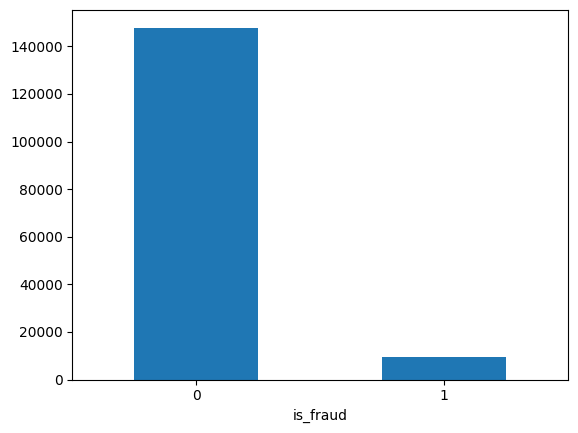

In [10]:
y_train.value_counts().plot(kind = "bar")
plt.xticks(rotation = 0)
plt.show()

To analyse for patterns, we need to combine X_train and y_train.<br>
Sequence of analysis is as follows:

1) counter_status
2) reading_remark
3) months_number, invoice_date related
4) num_days_since_creation
5) index_range, old_index, new_index
6) consumption_level

In [11]:
train = pd.concat([X_train, y_train], axis = 1)

def annotate_plot(ax, prec):
    for p in ax.patches:
        height = round(p.get_height(), prec)
        ax.annotate(f'{height}',
                    xy = (p.get_x() + p.get_width() / 2, height),
                    va = "bottom",
                    ha = "center"
        )

Analysis for counter_status_mode:<br>
Non-differentiating so we drop.

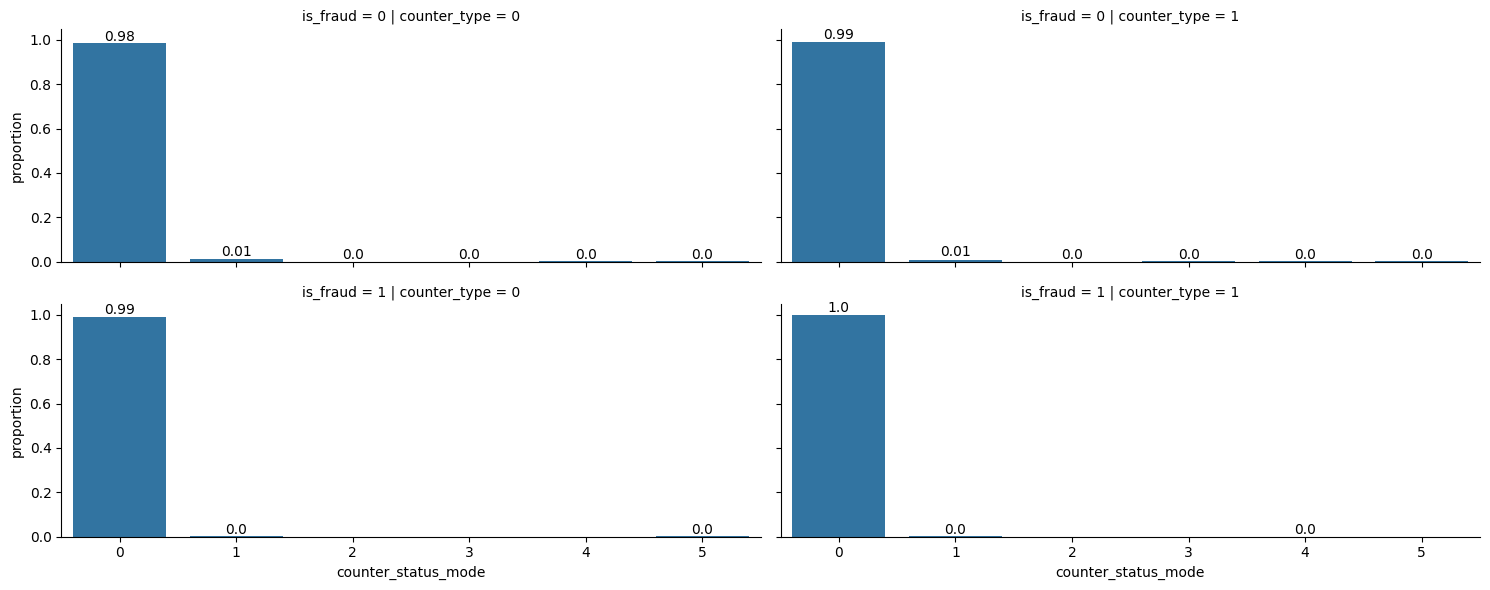

In [12]:
g = sns.FacetGrid(train, row = "is_fraud", col = "counter_type", aspect = 2.5)
g.map_dataframe(sns.countplot, "counter_status_mode", stat = "proportion")

for ax in g.axes.flat:
    annotate_plot(ax, 2)

analysis for reading_remark_mode:<br>
reading_remark_mode: non-differentiating so we drop<br>
reading_remark_column_range: quite differentiating

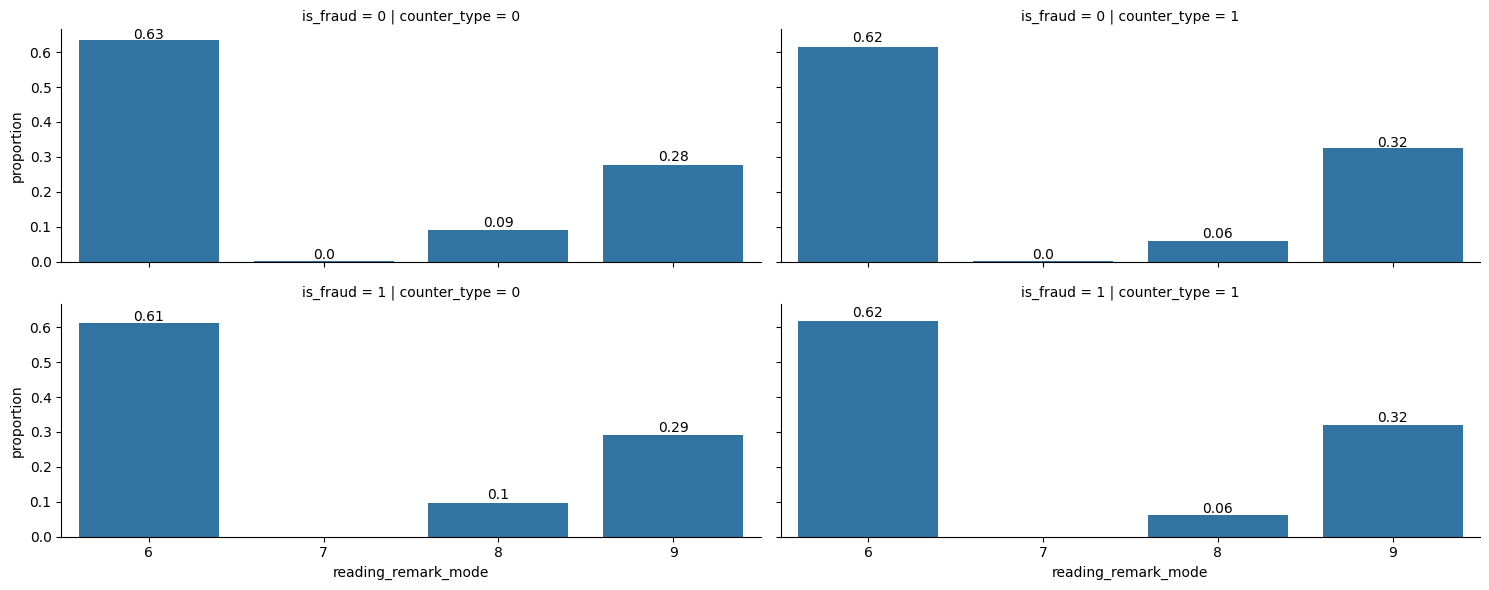

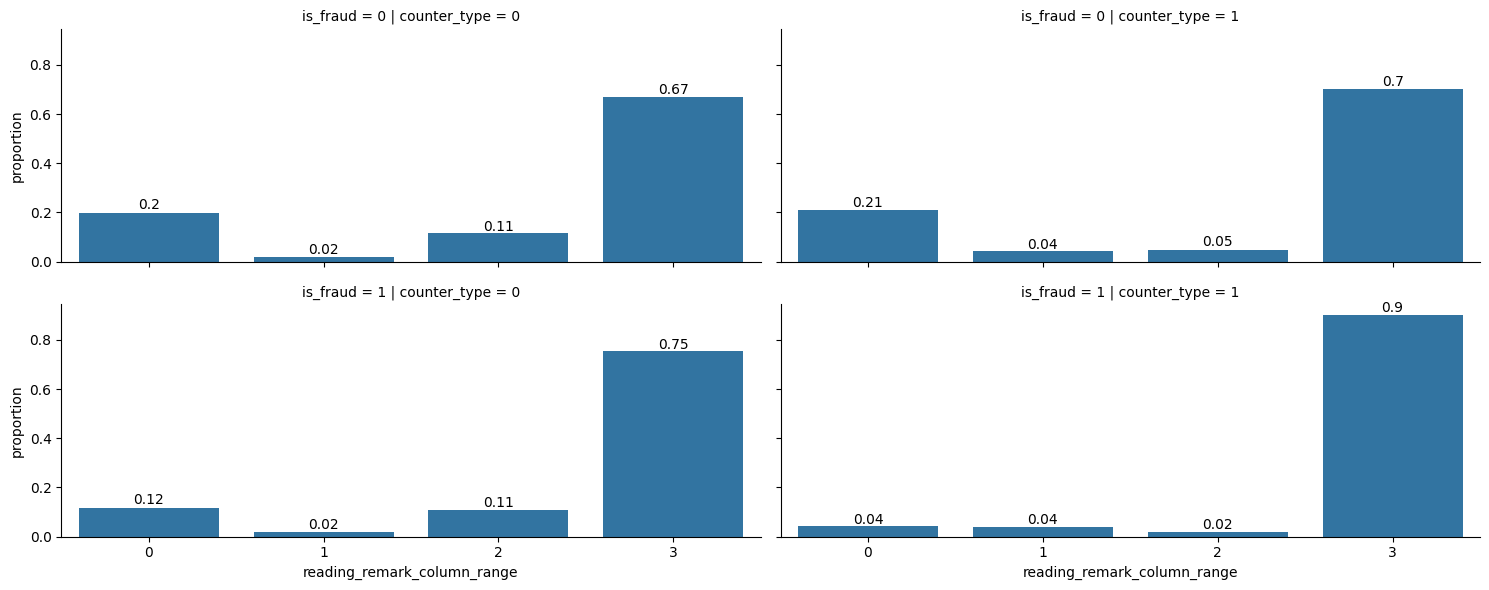

In [13]:
g = sns.FacetGrid(train, row = "is_fraud", col = "counter_type", aspect = 2.5)
g.map_dataframe(sns.countplot, "reading_remark_mode", stat = "proportion")

for ax in g.axes.flat:
    annotate_plot(ax, 2)

g = sns.FacetGrid(train, row = "is_fraud", col = "counter_type", aspect = 2.5)
g.map_dataframe(sns.countplot, "reading_remark_column_range", stat = "proportion")

for ax in g.axes.flat:
    annotate_plot(ax, 2)

analysis for counter_coefficient<br>
counter_coefficient_mode: non-differentiating so we drop.
counter_coefficient_column_range: non-differentiating so we drop.

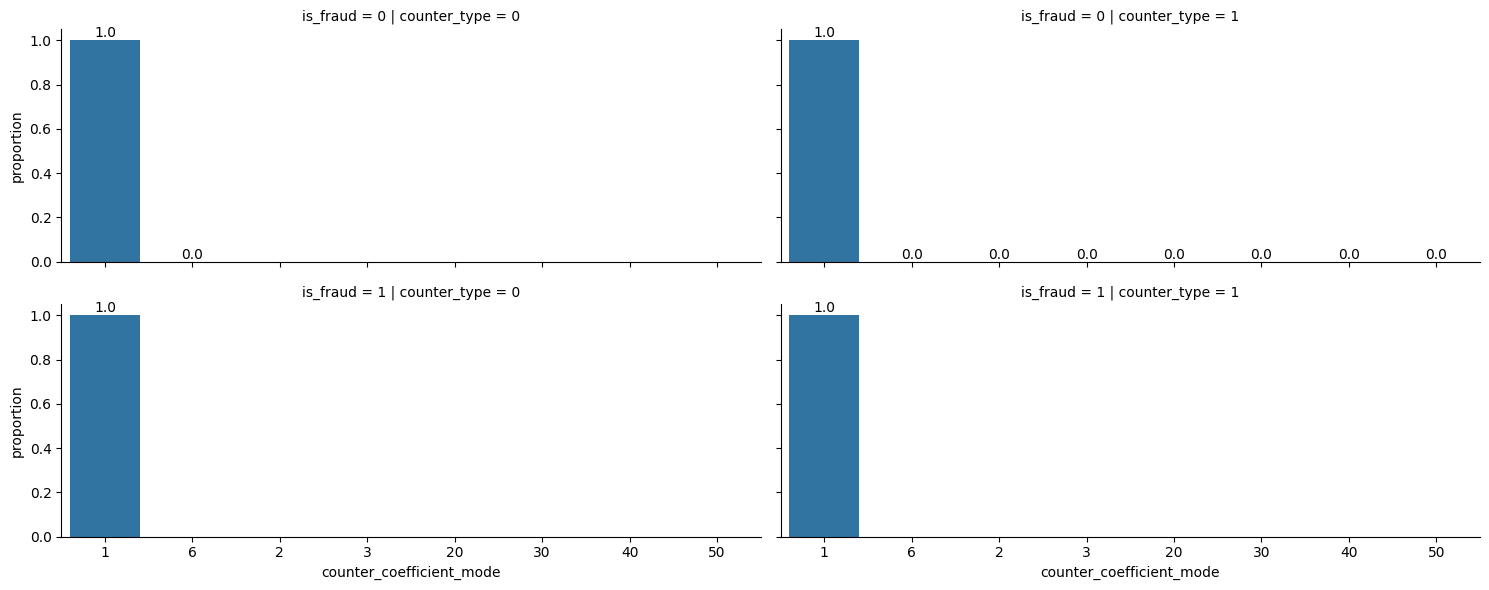

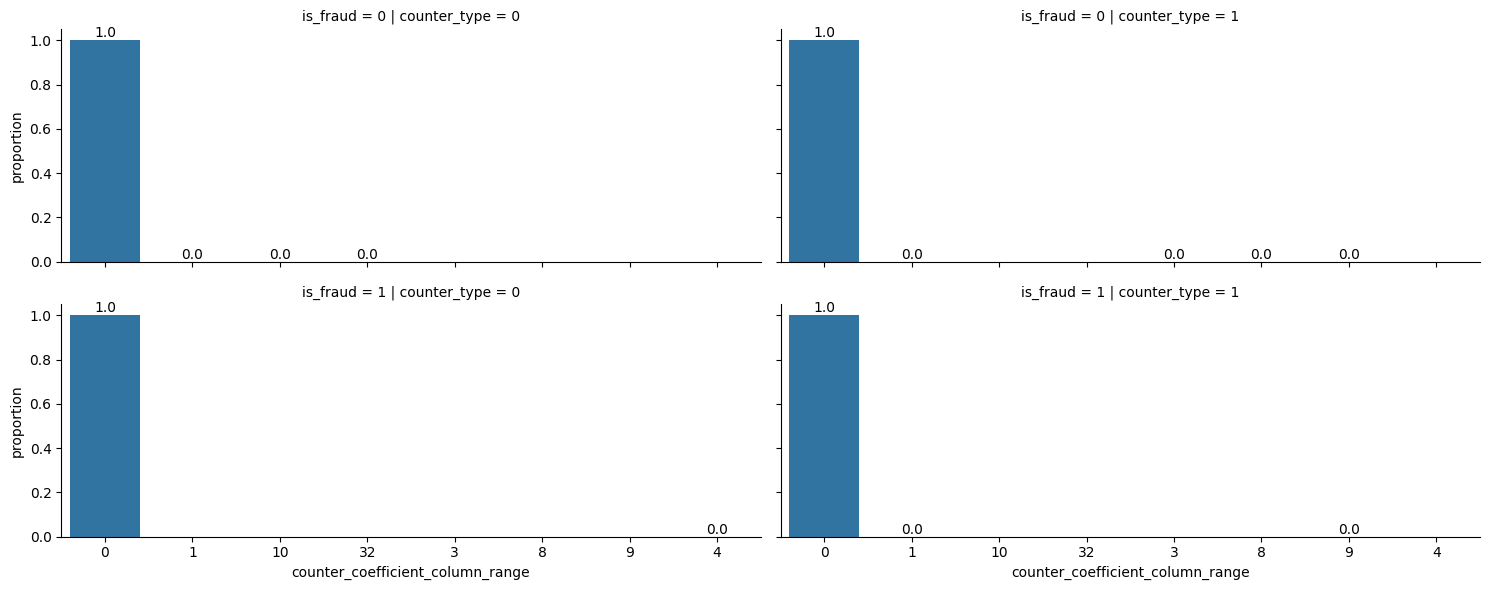

In [14]:
g = sns.FacetGrid(train, row = "is_fraud", col = "counter_type", aspect = 2.5)
g.map_dataframe(sns.countplot, "counter_coefficient_mode", stat = "proportion")

for ax in g.axes.flat:
    annotate_plot(ax, 2)

g = sns.FacetGrid(train, row = "is_fraud", col = "counter_type", aspect = 2.5)
g.map_dataframe(sns.countplot, "counter_coefficient_column_range", stat = "proportion")

for ax in g.axes.flat:
    annotate_plot(ax, 2)

analysis for months_number_mode<br>
Non-differentiating so we drop.

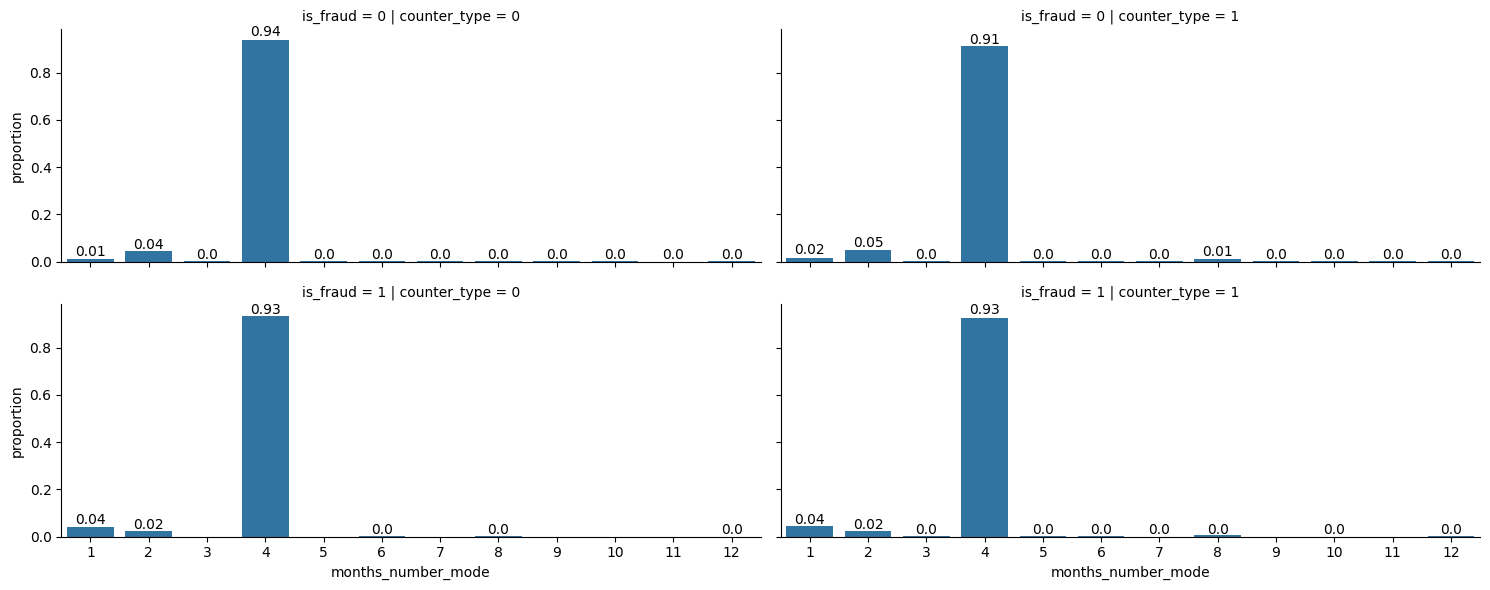

In [15]:
g = sns.FacetGrid(train, row = "is_fraud", col = "counter_type", aspect = 2.5)
g.map_dataframe(sns.countplot, "months_number_mode", stat = "proportion")

for ax in g.axes.flat:
    annotate_plot(ax, 2)

anaylsis for invoice_date_count:<br>
differences in summary statistics between fraud and non-fraud. useful for differentiating.

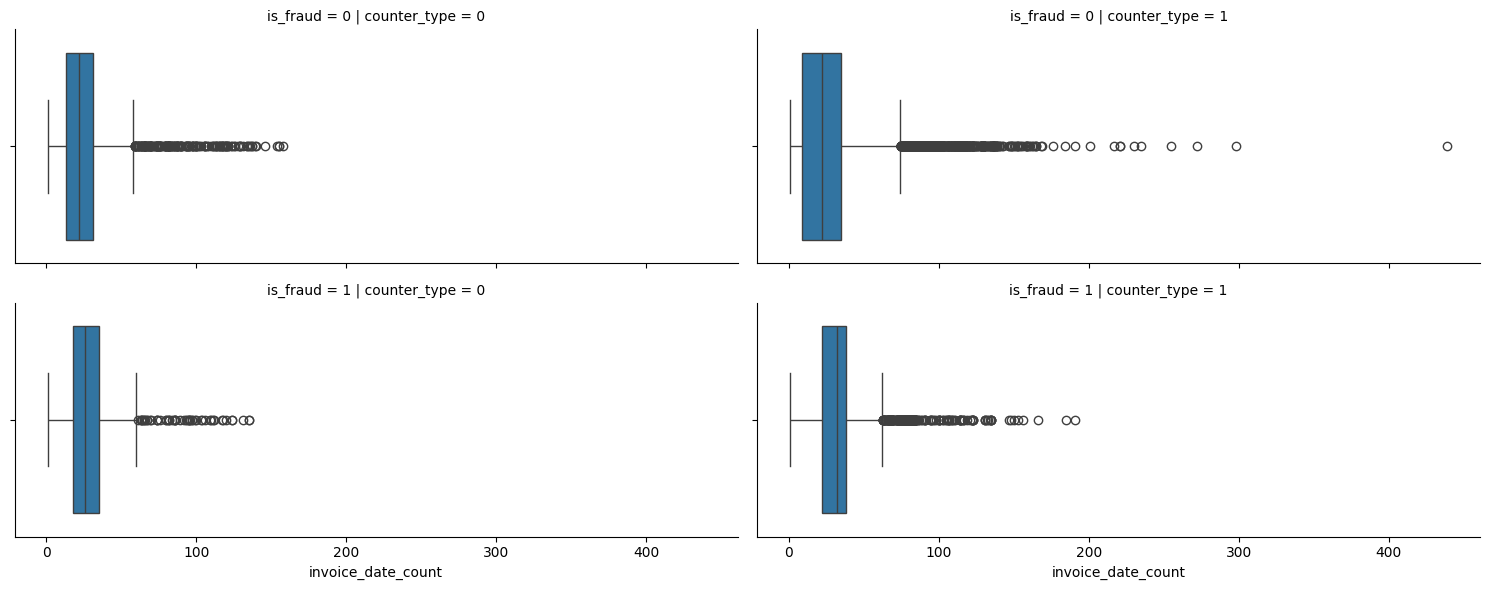

In [16]:
g = sns.FacetGrid(train, row = "is_fraud", col = "counter_type", aspect = 2.5)
g.map_dataframe(sns.boxplot, "invoice_date_count")

analysis for invoice_year:<br>
invoice_year_min: fraud only started in 2005. can remove rows with invoice_year_min 2004 and before to make dataset more balanced.<br>
invoice_year_column_range: differentiating so we can keep.

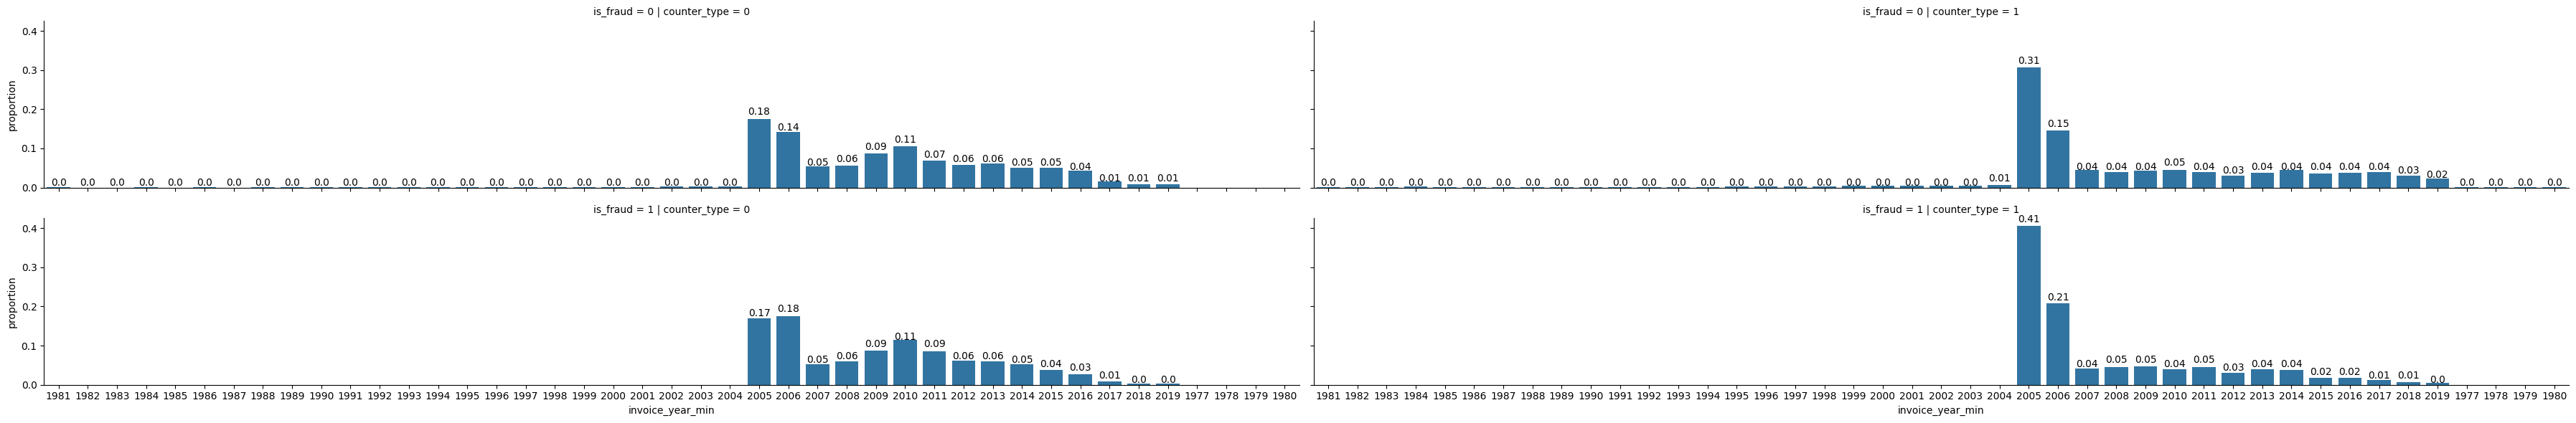

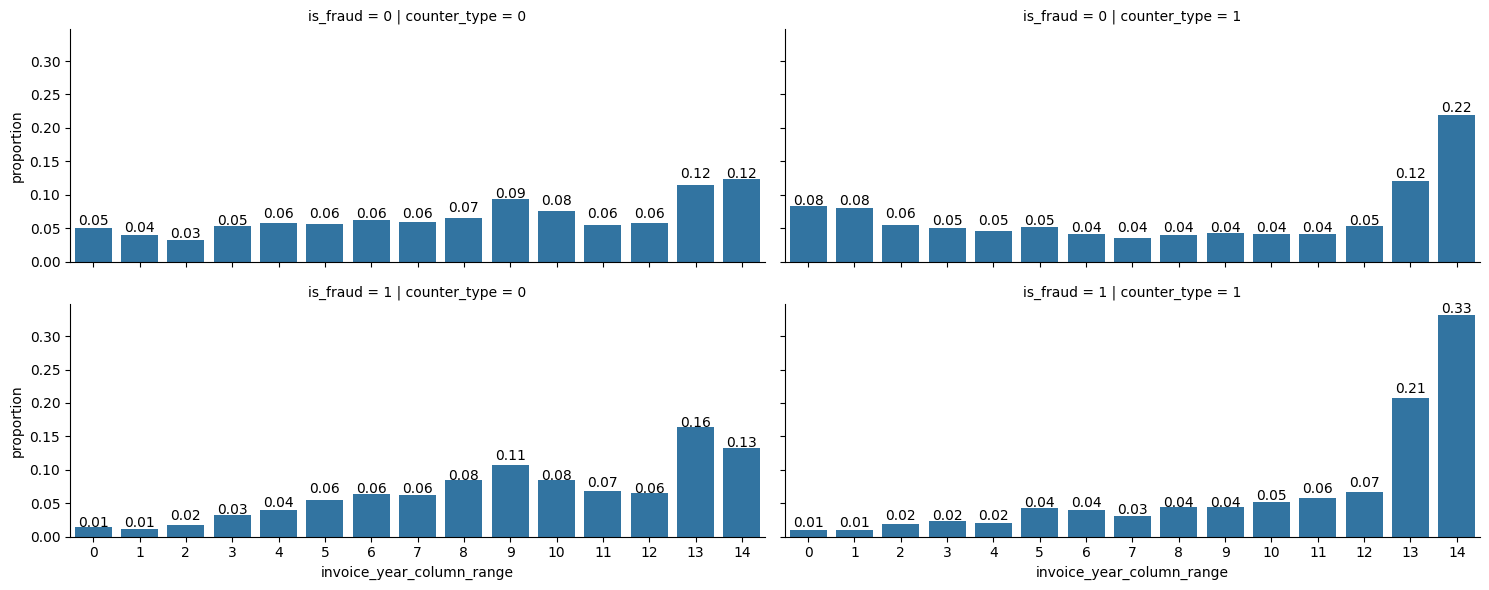

In [17]:
g = sns.FacetGrid(train, row = "is_fraud", col = "counter_type", aspect = 6)
g.map_dataframe(sns.countplot, "invoice_year_min", stat = "proportion")

for ax in g.axes.flat:
    annotate_plot(ax, 2)

g = sns.FacetGrid(train, row = "is_fraud", col = "counter_type", aspect = 2.5)
g.map_dataframe(sns.countplot, "invoice_year_column_range", stat = "proportion")

for ax in g.axes.flat:
    annotate_plot(ax, 2)

analysis for invoice_date_diff:
all relevant except invoice_date_min

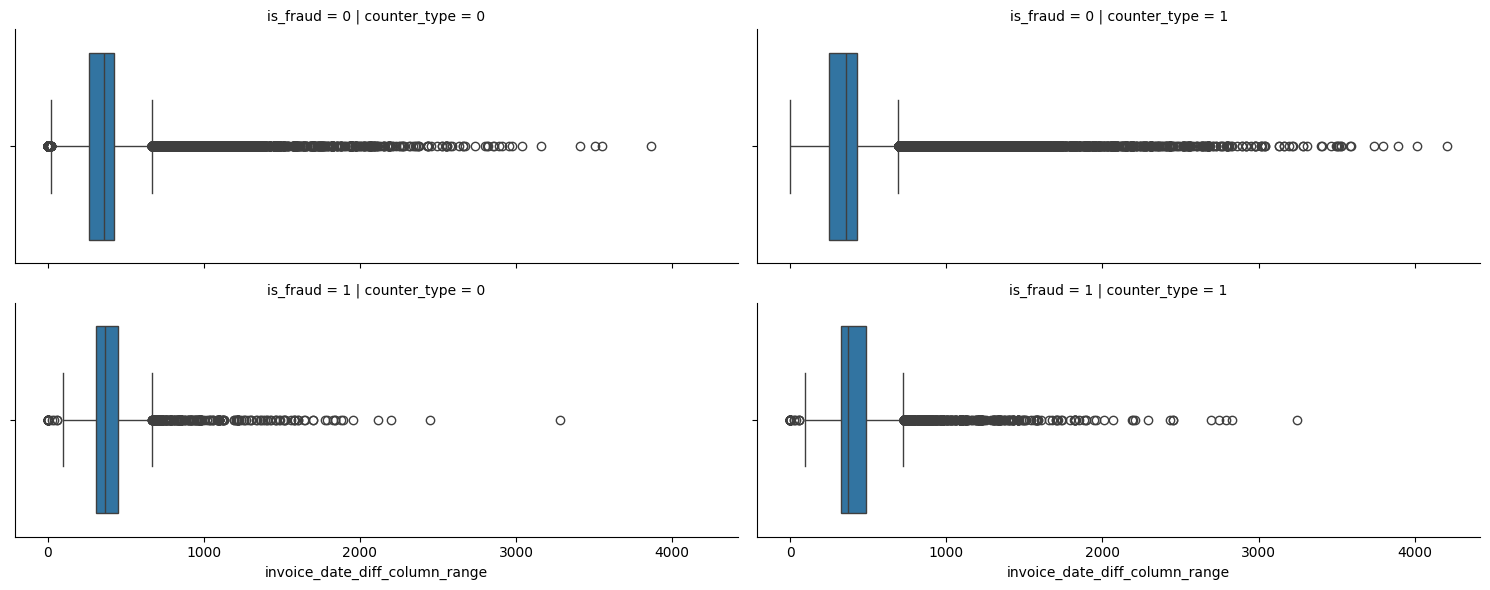

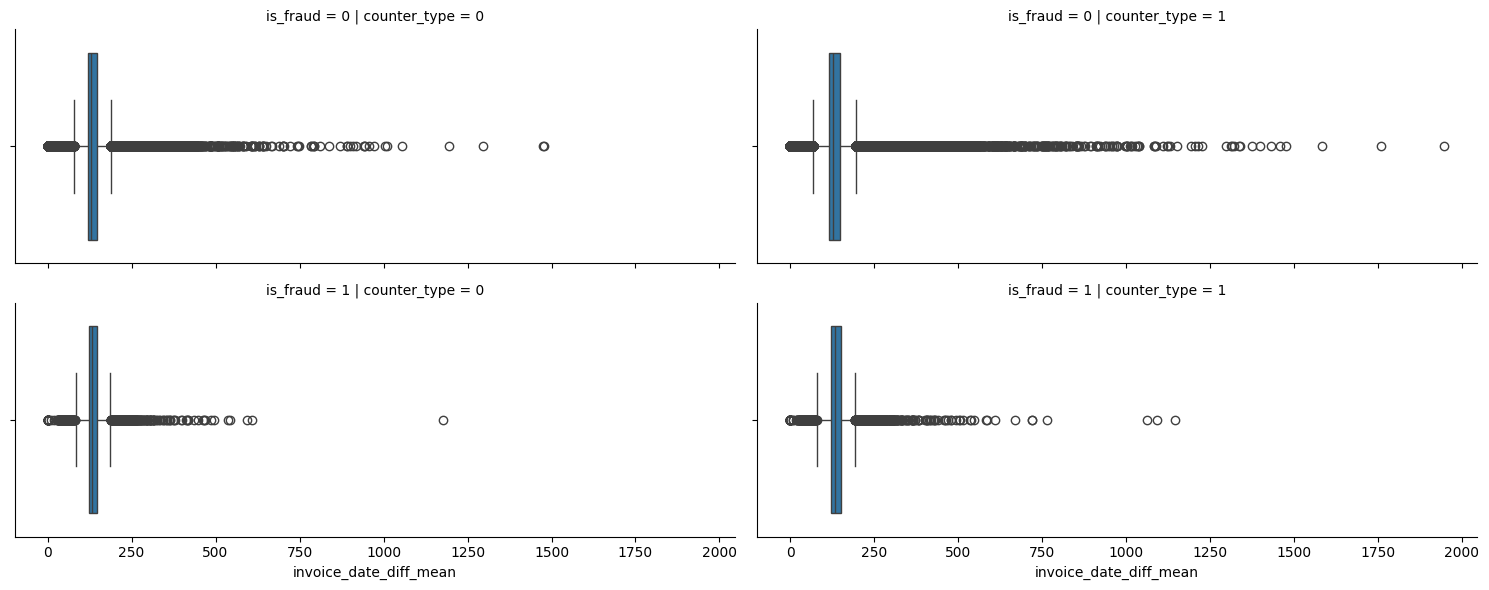

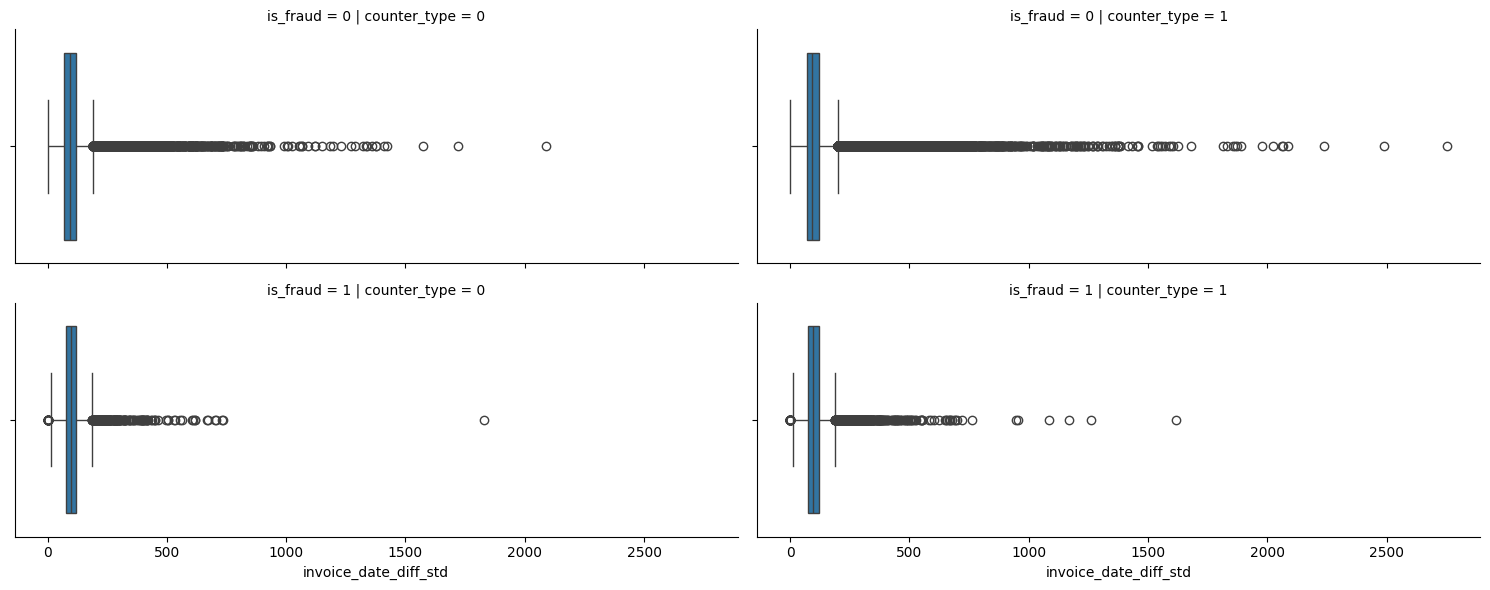

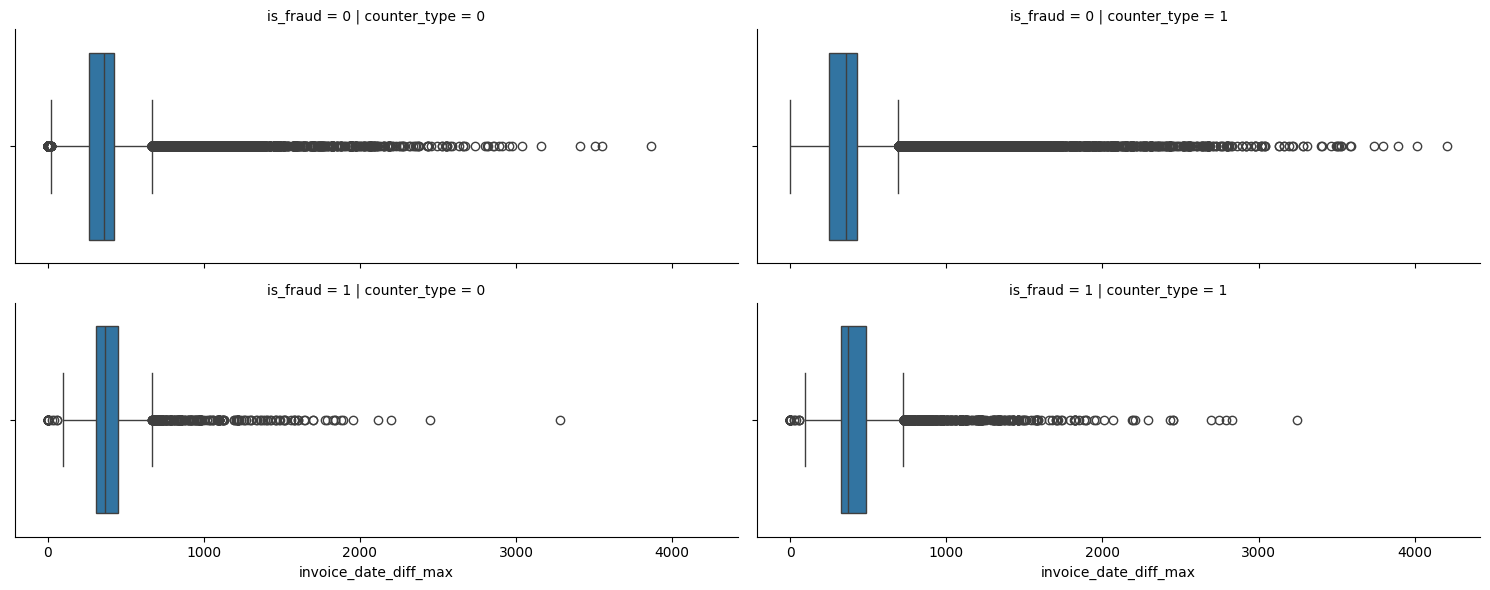

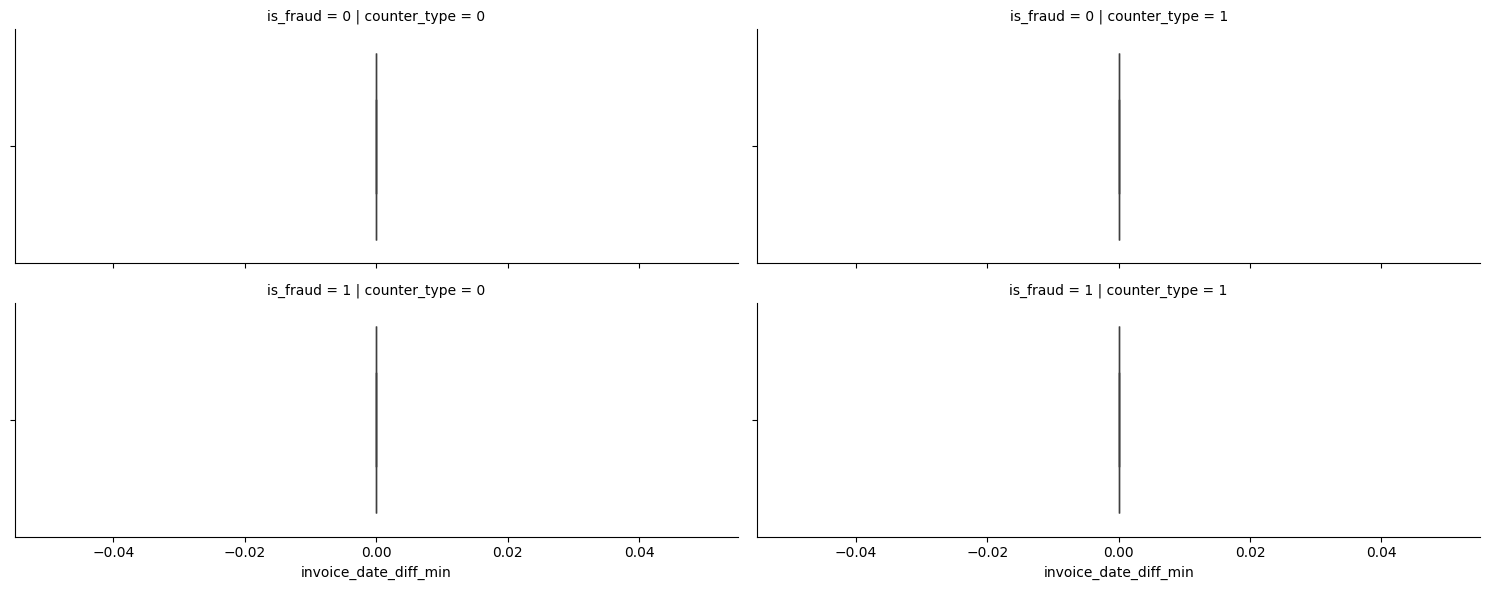

In [43]:
g = sns.FacetGrid(train, row = "is_fraud", col = "counter_type", aspect = 2.5)
g.map_dataframe(sns.boxplot, "invoice_date_diff_column_range")

g = sns.FacetGrid(train, row = "is_fraud", col = "counter_type", aspect = 2.5)
g.map_dataframe(sns.boxplot, "invoice_date_diff_mean")

g = sns.FacetGrid(train, row = "is_fraud", col = "counter_type", aspect = 2.5)
g.map_dataframe(sns.boxplot, "invoice_date_diff_std")

g = sns.FacetGrid(train, row = "is_fraud", col = "counter_type", aspect = 2.5)
g.map_dataframe(sns.boxplot, "invoice_date_diff_max")

g = sns.FacetGrid(train, row = "is_fraud", col = "counter_type", aspect = 2.5)
g.map_dataframe(sns.boxplot, "invoice_date_diff_min")

plt.show()

In [28]:
# Function takes in cleaned invoice_df to create new features and aggregates data by client_id, counter_type
def new_agg_invoice_by_client_by_counter_type(df):
    invoice = df.copy()
    
    # create invoice_month feature
    invoice["invoice_month"] = invoice["invoice_date"].dt.month

    # create invoice_year feature
    invoice["invoice_year"] = invoice["invoice_date"].dt.year

    # create invoice_date_diff feature
    invoice_days_sorted = invoice.sort_values(by = ["client_id", "invoice_date"], ascending = True)
    invoice_days_diff = invoice_days_sorted.groupby(["client_id", "counter_type"])["invoice_date"].diff().dt.days
    invoice_days_diff = pd.DataFrame(invoice_days_diff).fillna(0)
    invoice_days_diff.columns = ["invoice_date_diff"]
    invoice = invoice_days_sorted.join(invoice_days_diff)

    # create mean_consumption_level feature
    invoice["mean_consumption_level"] = invoice[["consumption_level_1", "consumption_level_2",
                                                 "consumption_level_3", "consumption_level_4"]].mean(axis = 1)
    
    # create cumsum features for all consumption
    consumption_cumsum_df = invoice[["client_id", "counter_type",
               "consumption_level_1", "consumption_level_2",
               "consumption_level_3", "consumption_level_4",
               "mean_consumption_level"]].groupby(["client_id", "counter_type"]).cumsum()
    invoice = invoice.join(consumption_cumsum_df, rsuffix = "_cumsum")

    # creat diff features for all consumption
    consumption_diff_df = invoice[["client_id", "counter_type",
        "consumption_level_1", "consumption_level_2",
        "consumption_level_3", "consumption_level_4",
        "mean_consumption_level"]].groupby(["client_id", "counter_type"]).diff()
    
    # fillna because diff will result in NA for the first entry of every group
    consumption_diff_df = consumption_diff_df.fillna(0)
    invoice = invoice.join(consumption_diff_df, rsuffix = "_diff")

    invoice_agg = invoice.groupby(["client_id", "counter_type"], as_index = False).agg({
        'reading_remark': column_range,
        'invoice_date': ['max', 'count'],
        'invoice_month': mode,
        'invoice_year': ['max', column_range],
        'invoice_date_diff': [column_range, 'mean', 'std', 'max', 'min'],
        'old_index': ['min', 'std'],
        'new_index': ['max', 'std'],
        'consumption_level_1': [column_range, 'mean', 'std', 'max', 'min'],
        'consumption_level_2': [column_range, 'mean', 'std', 'max', 'min'],
        #'consumption_level_3': [column_range, 'mean', 'std', 'max', 'min'],
        #'consumption_level_4': [column_range, 'mean', 'std', 'max', 'min'],
        'mean_consumption_level': [column_range, 'mean', 'std', 'max', 'min'],
        'consumption_level_1_cumsum': [column_range, 'mean', 'std', 'max', 'min'],
        'consumption_level_2_cumsum': [column_range, 'mean', 'std', 'max', 'min'],
        #'consumption_level_3_cumsum': [column_range, 'mean', 'std', 'max', 'min'],
        #'consumption_level_4_cumsum': [column_range, 'mean', 'std', 'max', 'min'],
        'mean_consumption_level_cumsum': [column_range, 'mean', 'std', 'max', 'min'],
        'consumption_level_1_diff': [column_range, 'mean', 'std', 'max', 'min'],
        'consumption_level_2_diff': [column_range, 'mean', 'std', 'max', 'min'],
        #'consumption_level_3_diff': [column_range, 'mean', 'std', 'max', 'min'],
        #'consumption_level_4_diff': [column_range, 'mean', 'std', 'max', 'min'],
        'mean_consumption_level_diff':[column_range, 'mean', 'std', 'max', 'min'],
    })

    # rename columns because names will be nested in tuples after aggregation
    invoice_agg.columns = ['_'.join(col) if (col[1] != '') else ''.join(col) for col in invoice_agg.columns.values]

    # fillna from stdev of single rows
    invoice_agg = invoice_agg.fillna(0)

    return invoice_agg

In [29]:
client = clean_client(client_raw)
invoice = clean_invoice(invoice_raw)
invoice_by_client_by_counter_type = new_agg_invoice_by_client_by_counter_type(invoice)
invoice_by_client = merge_client_data(invoice_by_client_by_counter_type, client)
X = invoice_by_client.drop(["client_id", "is_fraud"], axis = 1)
y = invoice_by_client["is_fraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 42, stratify = y, test_size = 0.2)

In [ ]:
lgb_clf = lgb.LGBMClassifier(random_state = 42, scale_pos_weight = 10, n_jobs = 8)

lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)
y_pred_proba = lgb_clf.predict_proba(X_test)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_proba[:, 1]))

y_pred = lgb_clf.predict(X_train)
y_pred_proba = lgb_clf.predict_proba(X_train)
print(confusion_matrix(y_train, y_pred))
print(accuracy_score(y_train, y_pred))
print(precision_score(y_train, y_pred))
print(recall_score(y_train, y_pred))
print(f1_score(y_train, y_pred))
print(roc_auc_score(y_train, y_pred_proba[:, 1]))

feature_importance_values = list(zip(lgb_clf.feature_names_in_, lgb_clf.feature_importances_))
feature_importance_values.sort(key = lambda x: x[1], reverse = True)
feature_importance_values